<b>PASOS A SEGUIR:</b>
1. Carga y exploración de datos.
2. Definición de la variable objetivo <b>(y)</b>.
3. Selección y preparación de las características <b>(x)</b>.
4. Estandarización de los datos <b>(PASO CRUCIAL PARA K-NN)</b>
5. División de datos para entrenamiento y prueba.
6. Entrenamiento y evaluación del modelo K-NN.
7. Optimización para encontrar el mejor valor <k>k</b>

<h1>PASO 1: CARGA DE LIBRERÍAS Y DATOS</h1>

Primero importamos las librerías que necesitaremos. *pandas* para manejar los datos, y *scikit-learn* para el modelo y las métricas

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

nombre_archivo = "data_base.csv"

try:
    df = pd.read_csv(nombre_archivo, encoding="latin1", sep=";")
    print("Archivo cargado exitosamente.")
    print("Primeras 5 filas")
    display(df.head())
except FileNotFoundError:
    print(f"Error: El archivo '{nombre_archivo}' no se encontró.")

Archivo cargado exitosamente.
Primeras 5 filas


,NRC,Periodo,Asignatura,Momento,Salon,Tipo,Id_Docente,Responsable,Sede_Docente,Ubicaci¢n,Tipo_Curso,Plantilla,Total_Alistamiento,Total_Ejecucion,Total_Curso,Valoracion,Email_Enviado
0,43-300,202443,Metodolog¡a de la Investigac,3,B3-304,1,478259,AEMD,IBA,IBA,PD,INNOVAME,50,0,50,Desempe¤o insatisfactorio,-
1,43-303,202443,Formulaci¢n de Proyectos,1,B3-304,1,662326,ESP,IBA,IBA,PD,INNOVAME,30,"36,3","46,3",Desempe¤o insatisfactorio,SI
2,43-302,202443,Evaluaci¢n de Proyectos,2,B2-305,1,662326,ESP,IBA,IBA,PD,INNOVAME,20,30,50,Desempe¤o insatisfactorio,-
3,43-304,202443,Gerencia del Conoc y la Tecnol,2,VIRTU,2,846904,ESP,IBA,IBA,PD,INNOVAME,50,35,85,Desempe¤o Bueno,-
4,43-56330,202443,Electiva,2,B3-304,1,738598,ESP,IBA,IBA,PD,INNOVAME,50,40,90,Desempe¤o Bueno,-


<h1>PASO 2: Definir la Variable Objetivo (y)</h1>

Nuestro objetivo es predecir el desempeño de un curso. Crearemos una nueva columna Desempeño basada en la columna valoración.

Variable objetivo 'y' definida desde la columna 'Valoracion'.
Distribución de categorías:
Valoracion
Desempe¤o Bueno              899
Desempe¤o Excelente          210
No evaluada                   98
Desempe¤o Aceptable           30
Desempe¤o insatisfactorio     29
Name: count, dtype: int64


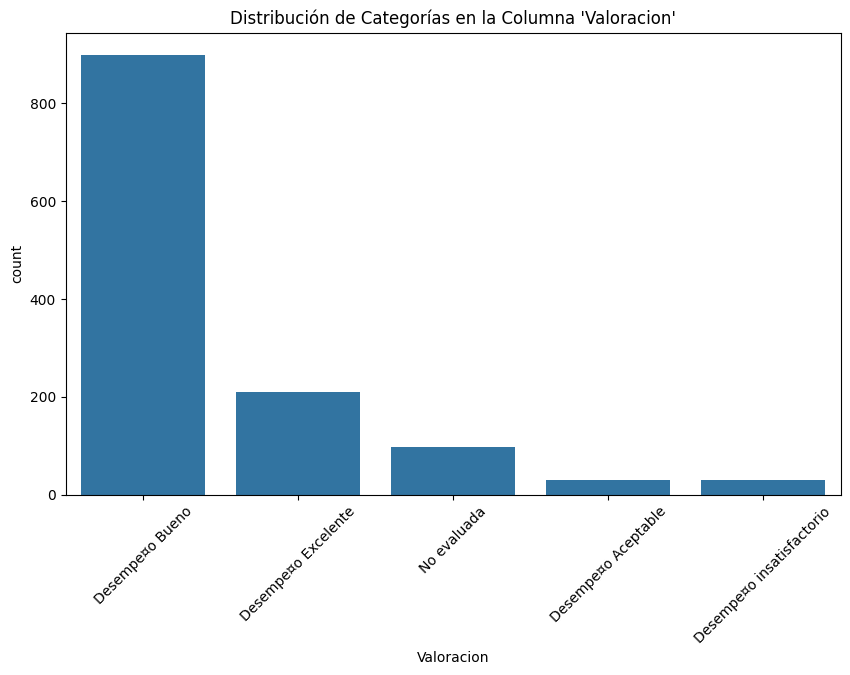

In [70]:
#La columna 'valoración' ya es nuestra variable objetivo y
y = df['Valoracion']

print("Variable objetivo 'y' definida desde la columna 'Valoracion'.")
print("Distribución de categorías:")
print(y.value_counts())

#Visualizamos la distribución
plt.figure(figsize=(10, 6))
sns.countplot(x=y, order=y.value_counts().index)
plt.title("Distribución de Categorías en la Columna 'Valoracion'")
plt.xticks(rotation=45) # Rotamos las etiquetas si son largas
plt.show()

<h1>PASO 3: Seleccionar y Preparar las Características (X)</h1>

Ahora seleccionamos las columnas que usaremos para predecir el desempeño. K-NN trabaja con números, por lo que debemos:

1. Seleccionar las columnas númericas relevantes.
2. Convertir las columnas de texto (categóricas) a formato numérico usando <b>One-Hot Encoding</b>

In [71]:
# Definimos la variable objetivo "y"
# y = df['Valoracion']

# Seleccionamos las características pra 'X'
# Columnas identificadoras como NRC, id_docente, etc... se excluyen
columnas_numericas = ['Total_Alistamiento','Total_Ejecucion']
columnas_categoricas = ['Momento', 'Sede_Docente', 'Tipo_Curso']



# Creamos el DataFrame de características X
x_numericas = df[columnas_numericas].copy()
x_categoricas = df[columnas_categoricas]

for col in columnas_numericas:
    # Check if the column is currently a string/object type (it should be)
    if x_numericas[col].dtype == 'object':
        x_numericas[col] = x_numericas[col].str.replace(',', '.', regex=False).astype(float)
        print(f"Columna '{col}' convertida a float.")
# Aplicamos One-Hot Encoding a las columnas categóricas
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
x_categoricas_encoded = pd.DataFrame(encoder.fit_transform(x_categoricas), columns=encoder.get_feature_names_out(columnas_categoricas))

# Unimos las características numéricas y las categóricas codificadas
x = pd.concat([x_numericas.reset_index(drop=True), x_categoricas_encoded.reset_index(drop=True)], axis=1)

print("Características 'x' preparadas. Dimensiones de x:" , x.shape)
print("Primeras filas de x:")
display(x.head())

Columna 'Total_Alistamiento' convertida a float.
Columna 'Total_Ejecucion' convertida a float.
Características 'x' preparadas. Dimensiones de x: (1266, 13)
Primeras filas de x:


,Total_Alistamiento,Total_Ejecucion,Momento_1,Momento_2,Momento_3,Momento_4,Sede_Docente_IBA,Sede_Docente_LA DORADA,Sede_Docente_LERIDA,Sede_Docente_No Encontrada,Sede_Docente_PUERTO BOYACA,Tipo_Curso_PD,Tipo_Curso_PP
0,50.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,30.0,36.3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,20.0,30.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,50.0,35.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,50.0,40.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


<h1>PASO 4: Estandarización de los Datos</h1>

K-NN se basa en distancias, por lo que es fundamental que todas las características estén en la misma escala. Se usa *StandardScaler* para que todas las columnas tengan una media de 0 y una desviación estándar de 1.

In [72]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

print("Datos estandarizados. El resultado es un array de NumPy.")

Datos estandarizados. El resultado es un array de NumPy.


<h1>PASO 5: División de Datos en Entrenamiento y Prueba</h1>

Dividimos nuestro conjunto de datos en dos partes:

- <b>80% para entrenamiento:</b> El modelo "aprenderá" de estos datos.
- <b>20% para prueba:</b> Usaremos estos datos para evaluar el rendimiento del modelo en casos que no ha visto.

In [73]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Datos de entrenamiento: {x_train.shape[0]} filas")
print(f"Datos de prueba: {x_test.shape[0]} filas")

Datos de entrenamiento: 1012 filas
Datos de prueba: 254 filas


<h1>PASO 6: Entrenamiento y Evaluación del Modelo K-NN</h1>

Ahora, creamos el clasificador K-NN. Empezaremos con un valor común para <b>k</b>, como 5, y luego se optimiza.

La exactitud de (accuracy) del modelo con K=5 es: 0.97

Reporte de clasificación:
                            precision    recall  f1-score   support

      Desempe¤o Aceptable       1.00      0.67      0.80         6
          Desempe¤o Bueno       0.96      1.00      0.98       180
      Desempe¤o Excelente       0.98      0.95      0.96        42
Desempe¤o insatisfactorio       1.00      0.83      0.91         6
              No evaluada       1.00      0.85      0.92        20

                 accuracy                           0.97       254
                macro avg       0.99      0.86      0.91       254
             weighted avg       0.97      0.97      0.97       254


Matriz de Confusión:


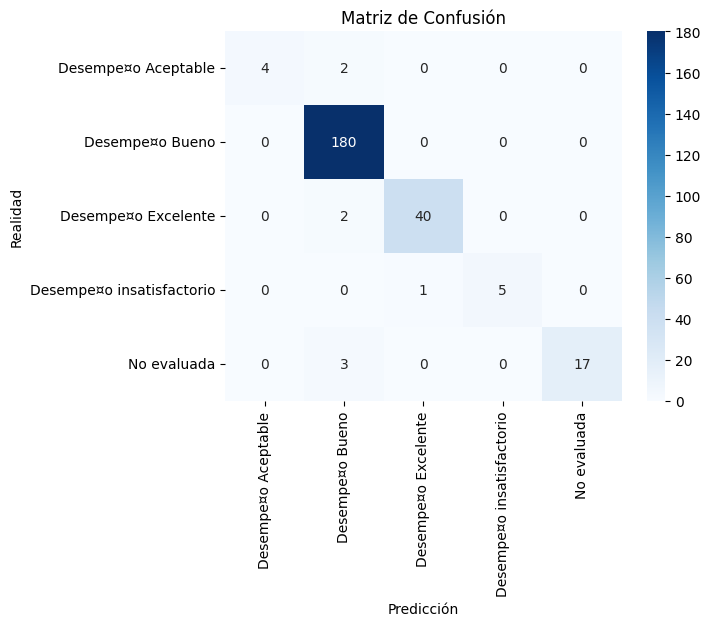

In [74]:
k = 5
knn = KNeighborsClassifier(n_neighbors=k)

# Entrenamos el modelo con los datos de entrenamiento
knn.fit(x_train, y_train)

# Hacemos predicciones con los datos de prueba
y_pred = knn.predict(x_test)

# Evaluamos el rendimiento
accuracy = accuracy_score(y_test, y_pred)
print(f"La exactitud de (accuracy) del modelo con K={k} es: {accuracy:.2f}")
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

# Conseguimos etiquetas únicas para la matriz de confusión
unique_labels = sorted(y_test.unique())

print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión')
plt.show()

<H1>PASO 7: OPTIMIZACIÓN PARA EL MEJOR VALOR DE K </H1>

In [ ]:
k_range = range(1, 30) # Test k=1, 3, 5, ..., 19
error_rate = []

# Loop through each k value
for k in k_range:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(x_train, y_train)
    y_pred_temp = knn_temp.predict(x_test)
    error_rate.append(1 - accuracy_score(y_test, y_pred_temp))

